In [0]:
!pip install -q fastai==0.7.0
!pip install -q torchtext==0.2.3

    100% |████████████████████████████████| 122kB 7.8MB/s 
    100% |████████████████████████████████| 1.5MB 15.3MB/s 
    100% |████████████████████████████████| 184kB 28.6MB/s 
    100% |████████████████████████████████| 3.6MB 10.8MB/s 
    100% |████████████████████████████████| 496.4MB 27kB/s 
    100% |████████████████████████████████| 12.5MB 2.5MB/s 
    100% |████████████████████████████████| 102kB 24.6MB/s 
    100% |████████████████████████████████| 61kB 20.7MB/s 
    100% |████████████████████████████████| 81kB 24.8MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
mizani 0.5.3 has requirement pandas>=0.23.4, but you'll have pandas 0.22.0 which is incompatible.
plotnine 0.5.1 has requirement pandas>=0.23.4, but you'll have pandas 0.22.0 which is incompatible.
    100% |████████████████████████████████| 51kB 4.9MB/s 


In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics
import feather

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
PATH = Path("data/sale/")
os.makedirs(PATH, exist_ok=True)

In [0]:
!kaggle competitions download -c competitive-data-science-predict-future-sales -p {PATH}

In [0]:
!cd {PATH} && ls *.gz | xargs -IX gunzip X
!ls {PATH}

item_categories.csv  items.csv	sales_train.csv  shops.csv  test.csv


## Look at Data Quickly

In [0]:
train = pd.read_csv(PATH/'sales_train.csv', low_memory=False)
test = pd.read_csv(PATH/'test.csv', low_memory=False)
shops = pd.read_csv(PATH/'shops.csv', low_memory=False)
items = pd.read_csv(PATH/'items.csv', low_memory=False)
cats = pd.read_csv(PATH/'item_categories.csv', low_memory=False)

In [0]:
display(train.head())
display(test.head())
display(shops.head())
display(items.head())
display(cats.head())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [0]:
train = train.merge(shops, on='shop_id')
train = train.merge(items, on='item_id')
train = train.merge(cats, on='item_category_id')
train.drop('item_category_id', 1, inplace=True)

g = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
g.columns = ['item_cnt_month']
g.item_cnt_month = g.item_cnt_month.clip(0, 20)
train = train.merge(g.reset_index(), how='left', on=['date_block_num','shop_id','item_id'])

g = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_price': ['mean']})
g.columns = ['item_price_month']
train = train.merge(g.reset_index(), how='left', on=['date_block_num','shop_id','item_id'])

train.drop(['date', 'item_price', 'item_cnt_day'], 1, inplace=True)
train.drop_duplicates(inplace=True)
train = train.sort_values('date_block_num').reset_index(drop=True)
train.head()

,date_block_num,shop_id,item_id,shop_name,item_name,item_category_name,item_cnt_month,item_price_month
0,0,59,22154,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,1.0,999.000000
1,0,8,14050,"Воронеж ТРЦ Сити-Парк ""Град""",ЛЮБОВЬ,Кино - DVD,1.0,349.000000
2,0,52,20005,"Уфа ТК ""Центральный""",Тренинг развития памяти (mp3-CD) (Jewel),Книги - Аудиокниги,1.0,249.000000
3,0,13,14050,"Казань ТЦ ""Бехетле""",ЛЮБОВЬ,Кино - DVD,2.0,224.000000
4,0,31,14050,"Москва ТЦ ""Семеновский""",ЛЮБОВЬ,Кино - DVD,7.0,334.571429


In [0]:
train_cats(train)
df, y, nas = proc_df(train, 'item_cnt_month')
nas

{}

In [0]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(df, y)
m.score(df, y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 2min 45s, sys: 142 ms, total: 2min 45s
Wall time: 1min 26s


0.9243853945527375

In [0]:
def split_by_len(x, n): return x[:n].copy(), x[n:].copy()

n = df.shape[0] - 220000
trn_x, val_x = split_by_len(df, n)
trn_y, val_y = split_by_len(y, n)
trn_df, val_df = split_by_len(train, n)
len(trn_x), len(val_x)

(1389124, 220000)

In [0]:
def rmse(x, t): return np.sqrt(np.mean((x - t) ** 2))

def show_results(m):
  res = [m.score(trn_x, trn_y), m.score(val_x, val_y)]
  if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
  res.append(rmse(m.predict(val_x), val_y))
  return res

m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(trn_x, trn_y)
show_results(m)

[0.9238985285348011,
 -0.02553727954247975,
 0.47282664895215065,
 2.334026797384531]

## EDA

In [0]:
train = pd.read_csv(PATH/'sales_train.csv', low_memory=False)
test = pd.read_csv(PATH/'test.csv', low_memory=False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


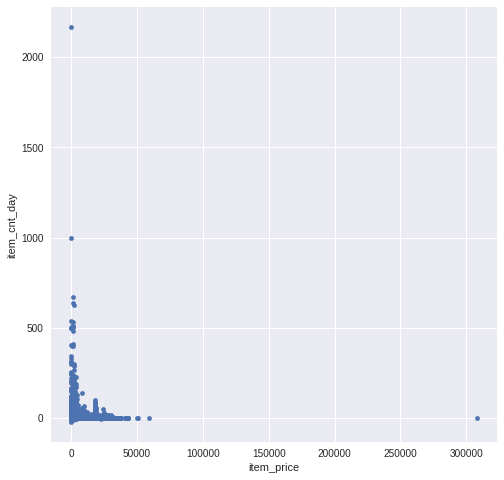

In [0]:
train.plot('item_price', 'item_cnt_day', 'scatter', figsize=(8, 8))

In [0]:
display(train[train.item_price > 300000])
display(train[train.item_cnt_day > 2000])
display(train[train.item_cnt_day == 1000])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2169.0


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.0,1000.0


In [0]:
6066 in test.item_id.values, 11373 in test.item_id.values, 20949 in test.item_id.values

(False, True, True)

In [0]:
display(train[train.item_id == 6066])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [0]:
train[train.item_id == 11373].describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,464.000000,464.0,464.0,464.000000,464.000000
mean,19.948276,12.0,11373.0,367.548909,14.144397
std,8.817658,0.0,0.0,296.953061,104.604937
min,0.000000,12.0,11373.0,0.908714,1.000000
25%,13.000000,12.0,11373.0,184.616848,2.000000
50%,21.000000,12.0,11373.0,281.625000,4.000000
75%,28.000000,12.0,11373.0,443.083333,8.000000
max,33.000000,12.0,11373.0,2137.000000,2169.000000


In [0]:
train[train.item_id == 20949].describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,31340.000000,31340.000000,31340.0,31340.000000,31340.000000
mean,17.683344,31.632833,20949.0,4.914856,5.987301
std,8.255712,16.907710,0.0,0.398042,11.497655
min,3.000000,2.000000,20949.0,1.830000,-16.000000
25%,11.000000,18.000000,20949.0,5.000000,2.000000
50%,17.000000,30.000000,20949.0,5.000000,3.000000
75%,24.000000,46.000000,20949.0,5.000000,7.000000
max,33.000000,59.000000,20949.0,5.000000,1000.000000


In [0]:
train = train[(train.item_price < 100000) & (train.item_cnt_day <= 1000)]

In [0]:
train.item_price.describe()

count    2.935847e+06
mean     8.907489e+02
std      1.720490e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      5.920000e+04
Name: item_price, dtype: float64

In [0]:
train[train.item_price <= 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [0]:
train[(train.item_id == 2973) & (train.shop_id == 32)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
67427,29.01.2013,0,32,2973,2499.0,1.0
67428,25.01.2013,0,32,2973,2499.0,1.0
67429,22.01.2013,0,32,2973,2499.0,1.0
67430,21.01.2013,0,32,2973,2499.0,1.0
67431,18.01.2013,0,32,2973,2499.0,1.0
67432,17.01.2013,0,32,2973,2499.0,1.0
67433,15.01.2013,0,32,2973,2499.0,3.0
187844,05.02.2013,1,32,2973,2499.0,1.0
187845,14.02.2013,1,32,2973,2499.0,1.0
484682,23.05.2013,4,32,2973,1249.0,1.0


In [0]:
train.loc[train.item_price <= 0, 'item_price'] = 2499.0

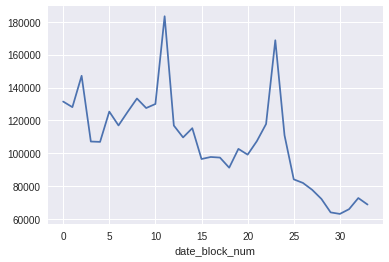

In [0]:
g = train.groupby(['date_block_num', 'item_id']).agg({'item_cnt_day': ['sum']})
g.columns = ['cnt_month']
g.groupby(['date_block_num']).cnt_month.sum().plot()

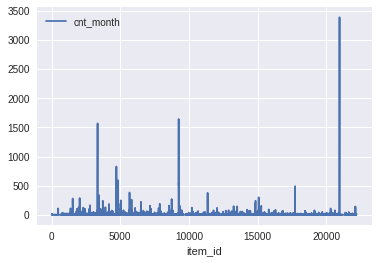

In [0]:
g.loc[32].plot()

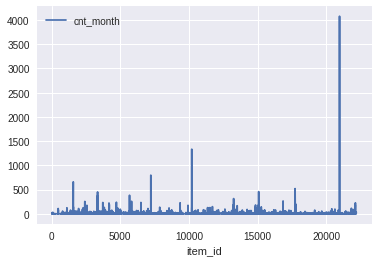

In [0]:
g.loc[33].plot()

In [0]:
item_last = np.unique(g.loc[31:].reset_index().item_id.values)
item_all = np.unique(g.reset_index().item_id.values)
n_item_outdated = len(list(set(item_all) - set(item_last)))
n_item_outdated, n_item_outdated / len(item_all)

(14620, 0.6704576722003118)

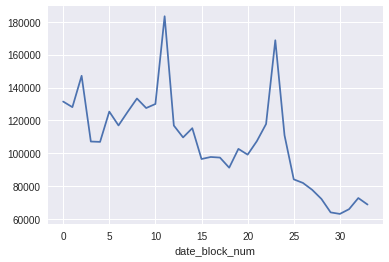

In [0]:
g = train.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_day': ['sum']})
g.columns = ['cnt_month']
g.groupby(['date_block_num']).cnt_month.sum().plot()

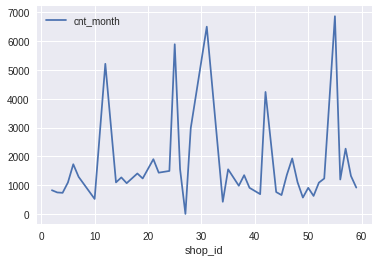

In [0]:
g.loc[32].plot()

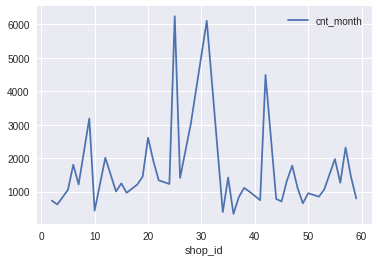

In [0]:
g.loc[33].plot()

In [0]:
shop_last = np.unique(g.loc[31:].reset_index().shop_id.values)
shop_all = np.unique(g.reset_index().shop_id.values)
n_shop_closed = len(list(set(shop_all) - set(shop_last)))
n_shop_closed, n_shop_closed / len(shop_all)

(14, 0.23333333333333334)

In [0]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [0]:
shops = pd.read_csv(PATH/'shops.csv', low_memory=False)
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [0]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
train.loc[train.shop_id == 39, 'shop_id'] = 40
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops.loc[shops.shop_name == 'Цифровой склад 1С-Онлайн', 'shop_name'] = 'Цифровойсклад 1С-Онлайн'
shops['city'] = shops.shop_name.str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['shop_type'] = shops.shop_name.str.split(' ')\
          .map(lambda x: 'ТЦ' if 'ТЦ' == x[1] else  'ТРЦ' if 'ТРЦ' == x[1] else
           'ТК' if 'ТК' == x[1] else 'ТРК' if 'ТРК' == x[1] else 'МТРЦ' if 'МТРЦ' == x[1] else 'other')
shops['city_code'] = LabelEncoder().fit_transform(shops['city']).astype(np.int8)
# shops['city_code'] = shops['city_code'].astype(np.int8)
shops['shop_type_code'] = LabelEncoder().fit_transform(shops['shop_type']).astype(np.int8)
# shops['shop_type_code'] = shops['shop_type_code'].astype(np.int8)
shops.head()

,shop_name,shop_id,city,shop_type,city_code,shop_type_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,other,29,0
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ,29,5
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ,0,5
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК,1,3
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ,2,5


In [0]:
items = pd.read_csv(PATH/'items.csv', low_memory=False)
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [0]:
items.loc[items.item_category_id == 40, 'item_name']

0                ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D
2            ***В ЛУЧАХ СЛАВЫ   (UNV)                    D
3          ***ГОЛУБАЯ ВОЛНА  (Univ)                      D
4              ***КОРОБКА (СТЕКЛО)                       D
5        ***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)         ...
6                 ***УДАР ПО ВОРОТАМ (UNI)               D
7               ***УДАР ПО ВОРОТАМ-2 (UNI)               D
8                 ***ЧАЙ С МУССОЛИНИ                     D
9            ***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI)             D
10               *ЗА ГРАНЬЮ СМЕРТИ                       D
11               *ЛИНИЯ СМЕРТИ                           D
13               *СПАСАЯ ЭМИЛИ                           D
14               *ЧОКНУТЫЙ ПРОФЕССОР /МАГИЯ/             D
15                  //АДРЕНАЛИН: ОДИН ПРОТИВ ВСЕХ (Регион)
16                              //МОНГОЛ С.Бодров (Регион)
17                         //НЕ ОСТАВЛЯЮЩИЙ СЛЕДА (Регион)
18               /БОМБА ДЛЯ НЕВЕСТЫ /2DVD/              

In [0]:
cats = pd.read_csv(PATH/'item_categories.csv', low_memory=False)
cats[cats.item_category_id == 40]

,item_category_name,item_category_id
40,Кино - DVD,40


In [0]:
items.loc[items.item_category_id == 45]

,item_name,item_id,item_category_id
133,1С:Аудиокниги. 25 знаменитых сказок,133,45
134,1С:Аудиокниги. Around the World in 80 days (by...,134,45
135,1С:Аудиокниги. Classical Mosaic. English Stori...,135,45
136,1С:Аудиокниги. Happy New English! (Best funny ...,136,45
138,1С:Аудиокниги. А. Некрасов. Приключения капита...,138,45
139,1С:Аудиокниги. А.М. Волков. Волшебник изумрудн...,139,45
140,1С:Аудиокниги. Аладдин и другие восточные сказ...,140,45
142,1С:Аудиокниги. Алексей Толстой. Приключения Бу...,142,45
143,1С:Аудиокниги. Аленький цветочек и другие сказ...,143,45
149,1С:Аудиокниги. Английский для детей. Слушай и ...,149,45


In [0]:
items.loc[134].item_name

'1С:Аудиокниги. Around the World in 80 days (by Jules Verne) (Jewel)'

In [0]:
item_names = items.item_name.values
pat = re.compile(r'\((.*?)\)', re.S)
features = []

for o in item_names:
  features.append(re.findall(pat, o)[-2:])
  
features[:5]

[['ПЛАСТ.'], [], ['UNV'], ['Univ'], ['СТЕКЛО']]

In [0]:
item_f1 = []
item_f2 = []

for o in features:
  if len(o) == 0:
    item_f1.append(np.nan)
    item_f2.append(np.nan)
  elif len(o) == 1:
    item_f1.append(o[0])
    item_f2.append(np.nan)
  else:
    item_f1.append(o[1])
    item_f2.append(o[0])

In [0]:
items['item_f1'] = pd.Series(item_f1)
items['item_f2'] = pd.Series(item_f2)
items['item_f1_code'] = LabelEncoder().fit_transform(items['item_f1'].fillna('xxx')).astype(np.int16)
items['item_f2_code'] = LabelEncoder().fit_transform(items['item_f2'].fillna('xxx')).astype(np.int16)
items.head()

,item_name,item_id,item_category_id,item_f1,item_f2,item_f1_code,item_f2_code
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,ПЛАСТ.,NaN,836,138
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,NaN,NaN,729,138
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,UNV,NaN,671,138
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Univ,NaN,673,138
4,***КОРОБКА (СТЕКЛО) D,4,40,СТЕКЛО,NaN,864,138


In [0]:
cats = pd.read_csv(PATH/'item_categories.csv', low_memory=False)
cats.loc[32, 'item_category_name'] = 'Карты оплаты - Кино, Музыка, Игры'
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else np.nan)
cats.drop('split', 1, inplace=True)
cats['type_code'] = LabelEncoder().fit_transform(cats['type']).astype(np.int8)
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'].fillna('xxx')).astype(np.int8)
cats.head()

,item_category_name,item_category_id,type,subtype,type_code,subtype_code
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники,0,29
1,Аксессуары - PS2,1,Аксессуары,PS2,1,9
2,Аксессуары - PS3,2,Аксессуары,PS3,1,10
3,Аксессуары - PS4,3,Аксессуары,PS4,1,11
4,Аксессуары - PSP,4,Аксессуары,PSP,1,13


In [0]:
cats[cats.subtype.isnull()]

,item_category_name,item_category_id,type,subtype,type_code,subtype_code
8,Билеты (Цифра),8,Билеты (Цифра),NaN,2,18
9,Доставка товара,9,Доставка товара,NaN,3,18
79,Служебные,79,Служебные,NaN,15,18
81,Чистые носители (шпиль),81,Чистые носители (шпиль),NaN,16,18
82,Чистые носители (штучные),82,Чистые носители (штучные),NaN,17,18
83,Элементы питания,83,Элементы питания,NaN,18,18


## Feature engineering

In [5]:
from itertools import product
from sklearn.preprocessing import LabelEncoder

In [6]:
items = pd.read_csv(f'{PATH}/items.csv')
shops = pd.read_csv(f'{PATH}/shops.csv')
cats = pd.read_csv(f'{PATH}/item_categories.csv')
train = pd.read_csv(f'{PATH}/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv(f'{PATH}/test.csv').set_index('ID')

In [7]:
train = train[(train.item_price < 100000) & (train.item_cnt_day <= 1000)]
train.loc[train.item_price <= 0, 'item_price'] = 2499.0

# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11
train.loc[train.shop_id == 39, 'shop_id'] = 40
test.loc[test.shop_id == 39, 'shop_id'] = 40
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops.loc[shops.shop_name == 'Цифровой склад 1С-Онлайн', 'shop_name'] = 'Цифровойсклад 1С-Онлайн'
shops['city'] = shops.shop_name.str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['shop_type'] = shops.shop_name.str.split(' ')\
          .map(lambda x: 'ТЦ' if 'ТЦ' == x[1] else  'ТРЦ' if 'ТРЦ' == x[1] else
           'ТК' if 'ТК' == x[1] else 'ТРК' if 'ТРК' == x[1] else 'МТРЦ' if 'МТРЦ' == x[1] else 'other')
shops['city_code'] = LabelEncoder().fit_transform(shops['city']).astype(np.int8)
shops['shop_type_code'] = LabelEncoder().fit_transform(shops['shop_type']).astype(np.int8)
shops = shops[['shop_id', 'city_code', 'shop_type_code']]

cats.loc[32, 'item_category_name'] = 'Карты оплаты - Кино, Музыка, Игры'
cats['type'] = cats['item_category_name'].str.split('-').map(lambda x: x[0].strip())
cats['subtype'] = cats['item_category_name'].str.split('-').map(lambda x: x[1].strip() if len(x) > 1 else np.nan)
cats['type_code'] = LabelEncoder().fit_transform(cats['type']).astype(np.int8)
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'].fillna('xxx')).astype(np.int8)
cats = cats[['item_category_id', 'type_code', 'subtype_code']]

item_names = items.item_name.values
pat = re.compile(r'\((.*?)\)', re.S)
item_f1, item_f2, features = [], [], []
for o in item_names:
  features.append(re.findall(pat, o)[-2:])
for o in features:
  if len(o) == 0:
    item_f1.append(np.nan)
    item_f2.append(np.nan)
  elif len(o) == 1:
    item_f1.append(o[0])
    item_f2.append(np.nan)
  else:
    item_f1.append(o[1])
    item_f2.append(o[0])
items['item_f1'] = pd.Series(item_f1)
items['item_f2'] = pd.Series(item_f2)
items['item_f1_code'] = LabelEncoder().fit_transform(items['item_f1'].fillna('xxx')).astype(np.int16)
items['item_f2_code'] = LabelEncoder().fit_transform(items['item_f2'].fillna('xxx')).astype(np.uint8)
items.drop(['item_f1', 'item_f2'], 1, inplace=True)
items.drop(['item_name'], 1, inplace=True)

In [ ]:
# if ran on google colab
# items.drop(['item_f1_code', 'item_f2_code'], 1, inplace=True)

In [8]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [9]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [10]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [11]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

In [12]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

matrix = pd.concat([matrix, test], ignore_index=True, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [16]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [14]:
%%time
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

CPU times: user 43.7 s, sys: 5.8 s, total: 49.5 s
Wall time: 29.2 s


#### mean encoding

In [17]:
%%time
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'item_category_id', 'item_f1_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_item_f1_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id', 'item_f1_code'], how='left')
matrix['date_cat_item_f1_avg_item_cnt'] = matrix['date_cat_item_f1_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_item_f1_avg_item_cnt')
matrix.drop(['date_cat_item_f1_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'item_category_id', 'item_f2_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_item_f2_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id', 'item_f2_code'], how='left')
matrix['date_cat_item_f1_avg_item_cnt'] = matrix['date_cat_item_f2_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_item_f2_avg_item_cnt')
matrix.drop(['date_cat_item_f2_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'shop_type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_type_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'item_id', 'shop_type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_shop_type_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_type_code'], how='left')
matrix['date_item_shop_type_avg_item_cnt'] = matrix['date_item_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_shop_type_avg_item_cnt')
matrix.drop(['date_item_shop_type_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'subtype_code', 'item_f1_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_item_f1_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code', 'item_f1_code'], how='left')
matrix['date_subtype_item_f1_avg_item_cnt'] = matrix['date_subtype_item_f1_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_item_f1_avg_item_cnt')
matrix.drop(['date_subtype_item_f1_avg_item_cnt'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'subtype_code', 'item_f2_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_item_f2_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code', 'item_f2_code'], how='left')
matrix['date_subtype_item_f2_avg_item_cnt'] = matrix['date_subtype_item_f2_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_item_f2_avg_item_cnt')
matrix.drop(['date_subtype_item_f2_avg_item_cnt'], axis=1, inplace=True)

CPU times: user 8min 6s, sys: 3min 4s, total: 11min 10s
Wall time: 4min 1s


#### price trend features

In [18]:
%%time
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

CPU times: user 4min 59s, sys: 31 s, total: 5min 30s
Wall time: 4min 13s


#### revenue trend features

In [19]:
%%time
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

CPU times: user 29.4 s, sys: 24.9 s, total: 54.2 s
Wall time: 15.8 s


#### the resident item features

In [20]:
%%time
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num

CPU times: user 17min 46s, sys: 1.65 s, total: 17min 48s
Wall time: 17min 47s


#### the resident item features

In [21]:
%%time
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num

CPU times: user 11min 5s, sys: 1.26 s, total: 11min 7s
Wall time: 11min 6s


#### new item features

In [22]:
%%time
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

CPU times: user 3.12 s, sys: 2.41 s, total: 5.52 s
Wall time: 2.04 s


In [23]:
matrix['year'] = matrix.date_block_num.map(lambda x: 2013 + x // 12).astype(np.int8)
matrix['month'] = matrix.date_block_num.map(lambda x: (x % 12) + 1).astype(np.int8)
matrix.reset_index(drop=True, inplace=True)

In [24]:
matrix.to_pickle(PATH/'matrix.pkl')

In [3]:
data = pickle.load(open(PATH/'matrix.pkl', 'rb'))
data = data[data.date_block_num > 11]
data.reset_index(drop=True, inplace=True)

In [4]:
dep_var = 'item_cnt_month'
cat_vars = ['date_block_num', 'item_id', 'shop_id', 'city_code', 'shop_type_code',
           'item_category_id', 'type_code', 'subtype_code', 'month', 'year']
contin_vars = list(set(data.columns) - set(cat_vars) - set([dep_var]))
len(cat_vars), len(contin_vars), len(data.columns)

(10, 39, 50)

In [5]:
for o in cat_vars:
  data[o] = data[o].astype('category').cat.as_ordered()
# for o in contin_vars:
#   data[o] = data[o].fillna(0).astype('float32')

In [6]:
[(o, len(data[o].cat.categories)+1) for o in cat_vars]

[('date_block_num', 24),
 ('item_id', 17433),
 ('shop_id', 54),
 ('city_code', 32),
 ('shop_type_code', 7),
 ('item_category_id', 81),
 ('type_code', 20),
 ('subtype_code', 59),
 ('month', 13),
 ('year', 3)]

## RF

In [7]:
df, y, nas = proc_df(data, dep_var)
nas

{'item_cnt_month_lag_1': 0.0,
 'item_cnt_month_lag_2': 0.0,
 'item_cnt_month_lag_3': 0.0,
 'item_cnt_month_lag_6': 0.0,
 'item_cnt_month_lag_12': 0.0,
 'date_avg_item_cnt_lag_1': 0.279,
 'date_item_avg_item_cnt_lag_1': 0.1277,
 'date_item_avg_item_cnt_lag_2': 0.1364,
 'date_item_avg_item_cnt_lag_3': 0.1428,
 'date_item_avg_item_cnt_lag_6': 0.1569,
 'date_item_avg_item_cnt_lag_12': 0.1837,
 'date_shop_avg_item_cnt_lag_1': 0.2307,
 'date_shop_avg_item_cnt_lag_2': 0.2341,
 'date_shop_avg_item_cnt_lag_3': 0.2332,
 'date_shop_avg_item_cnt_lag_6': 0.237,
 'date_shop_avg_item_cnt_lag_12': 0.2434,
 'date_cat_avg_item_cnt_lag_1': 0.2274,
 'date_cat_item_f1_avg_item_cnt_lag_1': 0.2046,
 'date_cat_item_f2_avg_item_cnt_lag_1': 0.2283,
 'date_shop_cat_avg_item_cnt_lag_1': 0.1569,
 'date_shop_type_avg_item_cnt_lag_1_x': 0.1744,
 'date_shop_subtype_avg_item_cnt_lag_1': 0.1576,
 'date_city_avg_item_cnt_lag_1': 0.2426,
 'date_shop_type_avg_item_cnt_lag_1_y': 0.288,
 'date_item_city_avg_item_cnt_lag_1':

In [8]:
df.date_block_num.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

In [9]:
trn_idxs = df[df.date_block_num < 22].index.values
val_idxs = df[df.date_block_num == 22].index.values
test_idxs = df[df.date_block_num == 23].index.values

trn_x, trn_y = df.loc[trn_idxs].copy(), y[trn_idxs].copy()
val_x, val_y = df.loc[val_idxs].copy(), y[val_idxs].copy()
test_x = df.loc[test_idxs].copy()

In [10]:
del data
import gc
gc.collect()

112

In [11]:
def rmse(x, t): return np.sqrt(np.mean((x - t) ** 2))
  
def show_results(m):
  res = [m.score(trn_x, trn_y), m.score(val_x, val_y)]
  if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
  res.append(rmse(m.predict(val_x), val_y))
  return res

In [25]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
%time m.fit(trn_x, trn_y)
show_results(m)

/home/alex/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


CPU times: user 5min 57s, sys: 29.5 s, total: 6min 26s
Wall time: 2min 20s


/home/alex/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[0.5325591159079617,
 0.3752106515417507,
 0.5227038231220662,
 0.8979843084539196]

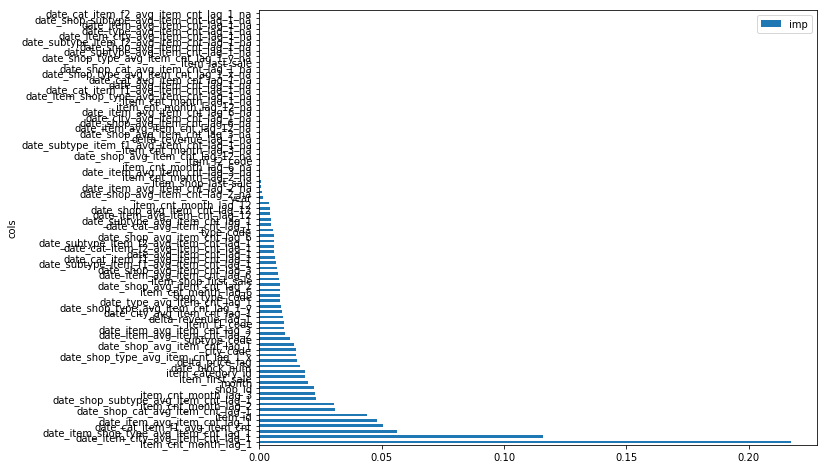

In [26]:
fi = rf_feat_importance(m, trn_x)
fi.plot('cols', 'imp', 'barh', figsize=(10, 8))

In [27]:
fi[20:]

,cols,imp
17,date_item_avg_item_cnt_lag_2,1.078607e-02
18,date_item_avg_item_cnt_lag_3,1.004789e-02
6,item_f1_code,1.001795e-02
42,delta_revenue_lag_1,9.896258e-03
33,date_city_avg_item_cnt_lag_1,9.421010e-03
34,date_shop_type_avg_item_cnt_lag_1_y,8.878013e-03
37,date_type_avg_item_cnt_lag_1,8.645224e-03
4,shop_type_code,8.624644e-03
13,item_cnt_month_lag_6,8.575114e-03
22,date_shop_avg_item_cnt_lag_2,8.435021e-03


In [28]:
keep = fi[fi.imp > 0.004].cols
pickle.dump(keep, open(PATH/'keep.pkl', 'wb'))

In [12]:
keep = pickle.load(open(PATH/'keep.pkl', 'rb'))
trn_x = trn_x[keep]
val_x = val_x[keep]
test_x = test_x[keep]

In [33]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=4, max_features=0.5, oob_score=True)
%time m.fit(trn_x, trn_y)
show_results(m)

/home/alex/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


CPU times: user 4min 16s, sys: 13.2 s, total: 4min 29s
Wall time: 1min 27s


/home/alex/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[0.5283864898099666,
 0.37657590348293346,
 0.5200241416189362,
 0.8970026613695433]

In [ ]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, max_features='log2', oob_score=True)
%time m.fit(trn_x, trn_y)
show_results(m)

In [ ]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, max_features='sqrt', oob_score=True)
%time m.fit(trn_x, trn_y)
show_results(m)

In [32]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=2, max_features=0.5, oob_score=True)
%time m.fit(trn_x, trn_y)
show_results(m)

/home/alex/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


CPU times: user 4min 11s, sys: 13.5 s, total: 4min 24s
Wall time: 1min 27s


/home/alex/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[0.5387094609466374,
 0.3783241183414735,
 0.5268231237779454,
 0.8957440845089103]

In [34]:
m = RandomForestRegressor(n_estimators=120, n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
%time m.fit(trn_x, trn_y)
show_results(m)

/home/alex/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


CPU times: user 12min 46s, sys: 38.7 s, total: 13min 25s
Wall time: 4min 13s


/home/alex/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[0.5384021046588424,
 0.38571421105968695,
 0.5286384392316963,
 0.8904041458506617]

In [13]:
set_rf_samples(500000)
len(trn_x), 500000 / len(trn_x)

(6115195, 0.08176354147332995)

In [14]:
m = RandomForestRegressor(n_estimators=400, n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
%time m.fit(trn_x, trn_y)
show_results(m)

/home/alex/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


CPU times: user 3h 18min 16s, sys: 2min 47s, total: 3h 21min 3s
Wall time: 30min 5s


/home/alex/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[0.6248771505427018,
 0.40001388910585356,
 0.5843704869177022,
 0.8799794652507853]

In [19]:
yp = m.predict(test_x)
test  = pd.read_csv(f'{PATH}/test.csv').set_index('ID')
sub = pd.DataFrame({'ID': test.index.values, 'item_cnt_month': yp})
sub.to_csv('submission.csv', index=False)